In [14]:
import os
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import *
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataPath = os.path.abspath(os.path.join('Data', 'power_data.csv'))
data = pd.read_csv(dataPath, sep = ',')

In [3]:
#convert dates to timestamps
data['Date'] = pd.to_datetime(data['Date'])
#set date as index
data = data.set_index('Date')
data.head()

,Unnamed: 0,Consumption,Wind,Solar,Wind+Solar
Date,,,,,
2006-01-01,0,1069.184,NaN,NaN,NaN
2006-01-02,1,1380.521,NaN,NaN,NaN
2006-01-03,2,1442.533,NaN,NaN,NaN
2006-01-04,3,1457.217,NaN,NaN,NaN
2006-01-05,4,1477.131,NaN,NaN,NaN


# model objectives

### Goals of Prediction
Our aim is to predict Consumption (ideally for future unseen dates) from this time series dataset.
### Training and Test set
We will be using 10 years of data for training i.e. 2006–2016 and last year’s data for testing i.e. 2017.
### Performance Measure
In order to evaluate how good our model is, we would be using R-squared and Root Mean Squared Error

# Helper functions

In [4]:
#regression metrics
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse  = metrics.mean_squared_error(y_true, y_pred)
    mean_square_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

# Feature engineering
As a baseline, we choose a simplistic model, one that predicts today’s consumption value based on
yesterday’s consumption value and;<br>
difference between yesterday and the day before yesterday’s consumption value.

In [5]:
# creating new dataframe from consumption column
data_consumption = data[['Consumption']]
# inserting new column with yesterday's consumption values
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,'Consumption'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()
# dropping NAs
data_consumption = data_consumption.dropna()
#print
data_consumption.head()

C:\Users\auria\Anaconda3\envs\timeSeries\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\auria\Anaconda3\envs\timeSeries\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Consumption,Yesterday,Yesterday_Diff
Date,,,
2006-01-03,1442.533,1380.521,311.337
2006-01-04,1457.217,1442.533,62.012
2006-01-05,1477.131,1457.217,14.684
2006-01-06,1403.427,1477.131,19.914
2006-01-07,1300.287,1403.427,-73.704


# Defining training and test sets

In [6]:
X_train  = data_consumption[:'2016'].drop(['Consumption'], axis = 1)
y_train = data_consumption.loc[:'2016', 'Consumption']

X_test  = data_consumption['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption.loc['2017', 'Consumption']

In [7]:
X_train.head()

,Yesterday,Yesterday_Diff
Date,,
2006-01-03,1380.521,311.337
2006-01-04,1442.533,62.012
2006-01-05,1457.217,14.684
2006-01-06,1477.131,19.914
2006-01-07,1403.427,-73.704


# forward chaining strategy for time series cross validation
In forward chaining, say with 3 folds, the train and validation sets look like: <br>
fold 1: training, validation <br>
fold 2: training, validation <br>
fold 3: training, validation<br>
where 1, 2, 3, 4 represent the year. This way successive training sets are supersets of those that come before them. <br>
this is done wit sklearn TimeSeriesSplit method <br>
The TimeSerieSplit function takes as input the number of splits. Since our training data has 11 unique years (2006 -2016), we would be setting n_splits = 10. This way we have neat training and validation sets:<br>
fold 1: training [2006], validation [2007]<br>
fold 2: training [2006 2007], validation [2008]<br>
fold 3: training [2006 2007 2008], validation [2009]<br>
fold 4: training [2006 2007 2008 2009], validation [2010]<br>
fold 5: training [2006 2007 2008 2009 2010], validation [2011]<br>
fold 6: training [2006 2007 2008 2009 2010 2011], validation [2012]<br>
fold 7: training [2006 2007 2008 2009 2010 2011 2012], validation [2013]<br>
fold 8: training [2006 2007 2008 2009 2010 2011 2012 2013], validation [2014]<br>
fold 9: training [2006 2007 2008 2009 2010 2011 2012 2013 2014], validation [2015]<br>
fold 10: training [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015], validation [2016]<br>

# spot check algorithms

LR: 0.343747 (0.029773)


C:\Users\auria\Anaconda3\envs\timeSeries\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\auria\Anaconda3\envs\timeSeries\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\auria\Anaconda3\envs\timeSeries\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs faile

NN: 0.473225 (0.156088)
KNN: 0.646307 (0.083185)
RF: 0.610843 (0.084034)
SVR: -0.117944 (0.157755)


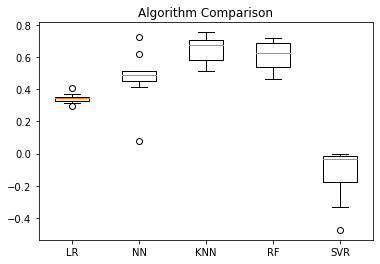

In [8]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

#evaluate each model in turn
results = []
names = []
for name, model in models:
    #time series cross validation
    tscv  = TimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv = tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
#compare algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()


# Grid Searching hyperparameters

In [9]:
#create custom scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_score = metrics.make_scorer(rmse, greater_is_better = False)


In [10]:
model = RandomForestRegressor()

param_search = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [i for i in range(5,15)]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, 
                      param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 50, 100]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [11]:
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
best_model

RandomForestRegressor(max_depth=8, max_features='log2')

# Checking model performance

In [19]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

In [20]:
#Sklearn regression_results seems broken, here is is fixed
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [18]:
regression_results(y_true, y_pred)

explained_variance:  0.732
mean_squared_log_error:  0.0041
r2:  0.7299
MAE:  55.2807
MSE:  7313.2017
RMSE:  85.5173


# Feature engineering
Previous model was using values at t-1 to predict on date t, let us now use values from t-2

In [23]:
#copy of original dataframe
data_consumption_2o = data_consumption.copy()

#Insert column with yesterday-1 values
data_consumption_2o['Yesterday-1'] = data_consumption_2o['Yesterday'].shift()

#inserting column with difference in yesterday-1 and yesterday-2 values

data_consumption_2o['Yesterday-1 Diff'] = data_consumption_2o['Yesterday-1'].diff()

#Dropping NAs
data_consumption_2o = data_consumption_2o.dropna()

In [24]:
data_consumption_2o.head()

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1 Diff
Date,,,,,
2006-01-05,1477.131,1457.217,14.684,1442.533,62.012
2006-01-06,1403.427,1477.131,19.914,1457.217,14.684
2006-01-07,1300.287,1403.427,-73.704,1477.131,19.914
2006-01-08,1207.985,1300.287,-103.140,1403.427,-73.704
2006-01-09,1529.323,1207.985,-92.302,1300.287,-103.140


# Resetting the train and test sets

In [25]:
X_train_2o = data_consumption_2o[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o = data_consumption_2o.loc[:'2016', 'Consumption']

X_test = data_consumption_2o['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o.loc['2017', 'Consumption']

# Check if the best random forest model performs better using new predictors

In [26]:
model = RandomForestRegressor()

param_search = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [i for i in range(5,15)]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, 
                      param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train_2o, y_train_2o)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 50, 100]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [27]:
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
best_model

RandomForestRegressor(max_depth=11, max_features='sqrt', n_estimators=50)

In [28]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8372
mean_squared_log_error:  0.0025
r2:  0.8371
MAE:  40.5632
MSE:  4410.5303
RMSE:  66.4118


We can see that adding the price from 2 days ago improves regression metrics

# More feature engineering
let's see if assing the value of solar production is beneficial to predicting electricity consumption

In [30]:
data_consumption_2o_solar = data_consumption_2o.join(data[['Solar']])
data_consumption_2o_solar = data_consumption_2o_solar.dropna()
data_consumption_2o_solar.head()

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1 Diff,Solar
Date,,,,,,
2012-01-01,948.128,1077.625,-122.241,1199.866,-27.022,6.587
2012-01-02,1269.581,948.128,-129.497,1077.625,-122.241,6.574
2012-01-03,1334.745,1269.581,321.453,948.128,-129.497,24.679
2012-01-04,1347.136,1334.745,65.164,1269.581,321.453,14.681
2012-01-05,1376.658,1347.136,12.391,1334.745,65.164,5.071


In [40]:
X_train_2o_solar = data_consumption_2o_solar[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o_solar = data_consumption_2o_solar.loc[:'2016', 'Consumption']

X_test_2o_solar = data_consumption_2o_solar.loc['2017', :].drop('Consumption', axis = 1)
y_test_2o_solar = data_consumption_2o_solar.loc['2017', 'Consumption']

In [43]:
model = RandomForestRegressor()

param_search = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [i for i in range(5,15)]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, 
                      param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train_2o_solar, y_train_2o_solar)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 50, 100]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [44]:
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
best_model

RandomForestRegressor(max_depth=12, max_features='sqrt')

In [45]:
y_true = y_test_2o_solar.values
y_pred = best_model.predict(X_test_2o_solar)
regression_results(y_true, y_pred)

explained_variance:  0.8396
mean_squared_log_error:  0.0025
r2:  0.8394
MAE:  40.2213
MSE:  4349.7115
RMSE:  65.9523


# Variable importance plot

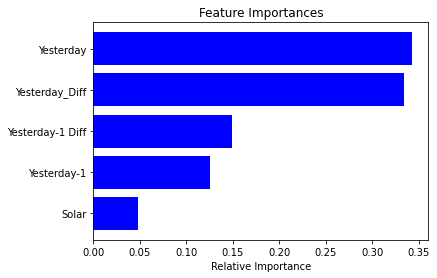

In [47]:
imp = best_model.feature_importances_
features = X_train_2o_solar.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()